In [16]:
import math
import numpy as np
from openbabel import pybel
import glob
import os
from typing import Tuple, List

class BindingPocket:
    def __init__(self, occupied_cells):
        self.occupied_cells = occupied_cells

def create_3d_grid(pocket, resolution):
    min_coords = np.min(pocket.occupied_cells, axis=0)
    shifted_coords = pocket.occupied_cells - min_coords
    
    max_coords = np.max(shifted_coords, axis=0)
    grid_shape = np.ceil((max_coords) / resolution).astype(int) + 1
    grid = np.zeros(grid_shape, dtype=bool)

    for cell in shifted_coords:
        cell_idx = np.floor(cell / resolution).astype(int)
        grid[tuple(cell_idx)] = True
    return grid

def intersection_over_union(pocket1, pocket2, resolution):
    grid1= create_3d_grid(pocket1, resolution)
    grid2 = create_3d_grid(pocket2, resolution)
    
    common_grid_shape = np.maximum(grid1.shape, grid2.shape)
    
    grid1_padded = np.pad(
        grid1,
        [(0, int(common_grid_shape[i] - grid1.shape[i])) for i in range(3)],
        mode='constant',
        constant_values=False
    )
    
    grid2_padded = np.pad(
        grid2,
        [(0, int(common_grid_shape[i] - grid2.shape[i])) for i in range(3)],
        mode='constant',
        constant_values=False
    )
    intersection_grid = np.logical_and(grid1_padded, grid2_padded)
    union_grid = np.logical_or(grid1_padded, grid2_padded)
    
    intersection_volume = np.sum(intersection_grid) * resolution**3
    union_volume = np.sum(union_grid) * resolution**3
    
    return intersection_volume / union_volume
    
def intersection_over_lig(lig, pocket, resolution):
    grid1= create_3d_grid(lig, resolution)
    grid2 = create_3d_grid(pocket, resolution)
    
    common_grid_shape = np.maximum(grid1.shape, grid2.shape)
    
    grid1_padded = np.pad(
        grid1,
        [(0, int(common_grid_shape[i] - grid1.shape[i])) for i in range(3)],
        mode='constant',
        constant_values=False
    )
    
    grid2_padded = np.pad(
        grid2,
        [(0, int(common_grid_shape[i] - grid2.shape[i])) for i in range(3)],
        mode='constant',
        constant_values=False
    )
    
    intersection_grid = np.logical_and(grid1_padded, grid2_padded)

    intersection_volume = np.sum(intersection_grid) * resolution**3
    lig_volume = np.sum(grid1_padded) * resolution**3
    
    return intersection_volume / lig_volume
def coordinates(pdb_file):
    molecule = next(pybel.readfile(pdb_file.split('.')[-1], pdb_file))
    ligand_coords = [atom.coords for atom in molecule.atoms]
    return np.array(ligand_coords)

def get_DVO(pkt1,pkt2,resolution = 1):
    pocket1_coords = coordinates(pkt1)
    pocket2_coords = coordinates(pkt2)
    pocket1 = BindingPocket(pocket1_coords)
    pocket2 = BindingPocket(pocket2_coords)
    return intersection_over_union(pocket1, pocket2, resolution)

def get_PLI(lig,pkt,resolution = 1):
    ligand_center = np.array(calculate_ligand_center(lig))
    labels, pkt_coords = labeling(pkt, ligand_center, threshold=10.0)
    lig_coords=coordinates(lig)
    pkt_coords=coordinates(pkt)
    ligand=BindingPocket(lig_coords)
    pocket=BindingPocket(pkt_coords)
    return intersection_over_lig(ligand,pocket,resolution)


def labeling(file_path: str, center_coordinates: List[float], threshold: float = 10.0) -> Tuple[str, str]:
    labels = []
    coords = []
    center_coordinates_array = np.array(center_coordinates)

    with open(file_path, 'r') as mol2_file:
        lines = mol2_file.readlines()

        for line in lines:
            if line.startswith('@<TRIPOS>BOND'):
                break

            split_line = line.split()
            if len(split_line) >= 7:
                atom_name = split_line[1]

                if atom_name == 'CA':
                    coord = np.array([float(split_line[2]), float(split_line[3]), float(split_line[4])])
                    distance = np.linalg.norm(coord - center_coordinates_array)

                    if distance <= threshold:
                        labels.append('1')
                        coords.append(coord)
                    else:
                        labels.append('0')
    if len(coord) == 0:
        print(f"Warning: No coordinates found for CA atoms in {file_path}")
        return '', ''
    
    label_coord = np.mean(coords, axis=0)


    return ''.join(labels), label_coord

def euclidean_distance(coord1: np.ndarray, coord2: np.ndarray) -> float:
    return np.linalg.norm(coord1 - coord2)

def calculate_ligand_center(mol2_file_path):
    """
    Given a path to a `ligand.mol2` file, calculates and returns the center coordinates of the ligand.

    Parameters:
    -----------
    mol2_file_path : str
        The path to the `ligand.mol2` file.

    Returns:
    --------
    tuple of floats
        The x, y, and z coordinates of the center of the ligand.
    """
    with open(mol2_file_path, 'r') as f:
        lines = f.readlines()

    lines = [line.split() for line in lines]

    x_sum, y_sum, z_sum, n_atoms = 0, 0, 0, 0

    for line in lines:
        if len(line) == 9:
            x, y, z, *_ = line[2:5]
            x_sum += float(x)
            y_sum += float(y)
            z_sum += float(z)
            n_atoms += 1
    center_x, center_y, center_z = x_sum/n_atoms, y_sum/n_atoms, z_sum/n_atoms
    
    return center_x, center_y, center_z

def get_DCC(ligand,protein):

    ligand_center = np.array(calculate_ligand_center(ligand))
    protein_center = np.array(calculate_ligand_center(protein))
    labels, protein_coords = labeling(protein, ligand_center, threshold=10.0)
    
    return euclidean_distance(ligand_center, np.array(protein_coords,dtype=np.float64))

def get_DCA(ligand, protein):

    ligand_coords = coordinates(ligand)
    protein_coords = coordinates(protein)

    min_distance = float('inf')

    for lig_atom in ligand_coords:
        for prot_atom in protein_coords:
            distance = euclidean_distance(lig_atom, prot_atom)
            if distance < min_distance:
                min_distance = distance

    return min_distance

In [18]:
total_score_gt = []
total_score = []
total_pli = []
dcc_scores = []
dca_scores = []
dccgt_scores = []

file_format = 'mol2'
k=0
path_list = os.listdir('./output/coach420')
datapath_gt_list = os.listdir('./coach420')

for i in list(range(len(path_list))):

    data_path = os.path.join('./output/coach420',path_list[i])

    datapath_gt = os.path.join('./coach420',path_list[i])
    
    ligand = os.path.join(datapath_gt,'ligand.'+file_format)
    gtpkt = os.path.join(datapath_gt,'protein.'+file_format)

    pkt = glob.glob(os.path.join(data_path, f'pocket*.{file_format}'))
    
    if pkt:
        pkt = pkt[0]
    
    dcc_score = get_DCC(ligand,pkt)
    dca_score = get_DCA(ligand,pkt)
    dcc_scores.append(dcc_score)
    dca_scores.append(dca_score)
    score_gt = get_DCC(ligand,gtpkt)
    dccgt_scores.append(score_gt)
    
    if dcc_score<float(4):
        score_pli = get_PLI(ligand,pkt)
        total_pli.append(score_pli)
        k+=1
        
    if math.isnan(dcc_score):
        pass
        
    else:
        total_score.append(dcc_score)
        total_score_gt.append(score_gt)

/home/dongwoo/anaconda3/envs/geo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dongwoo/anaconda3/envs/geo/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is ./2cx8/protein.pdb)

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is ./2cx8/protein.pdb)

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is ./2baw/protein.pdb)

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is ./2hxm/protein.pdb)

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is ./2hxm/protein.pdb)

*** Open Babel Warning  in ReadMo

TypeError: unhashable type: 'list'

In [38]:
import matplotlib.pyplot as plt

def draw_DCC(dcc_list, save_path, coach=False, bu48=False ):
    distance_count = [0] * 21
    for dcc in dcc_list:
        if dcc <= 20:
            distance_count[int(dcc)+1] += 1

    cumulative_values = [sum(distance_count[:i+1]) for i in range(len(distance_count))]
    percent_dcc = [value / len(dcc_list) * 100 for value in cumulative_values]
    print(percent_dcc[4])

    plt.figure(figsize=(10, 6))
    plt.xlim(-1, 21)
    plt.ylim(-5, 100)

    plt.plot([i for i in range(21)], percent_dcc, color='red', marker='.', label='ours')
    plt.xticks([i for i in range(21)], size=15)
    plt.yticks([i * 10 for i in range(10)], size=15)
    plt.title('Success rate', size=30)
    plt.xlabel('DCC ($\mathrm{\AA}$)', size=20)
    plt.ylabel('Percentage (%)', size=20)
    plt.axvline(x=4, color='r', linestyle='--')

    plt.grid(True)
    plt.savefig(save_path)

def draw_DCA(dcc_list, save_path):
    distance_count = [0] * 21
    for dcc in dcc_list:
        if dcc <= 20:
            distance_count[int(dcc)+1] += 1

    cumulative_values = [sum(distance_count[:i+1]) for i in range(len(distance_count))]
    percent_dcc = [value / len(dcc_list) * 100 for value in cumulative_values]
    print(percent_dcc[4])

    plt.figure(figsize=(10, 6))
    plt.xlim(-1, 21)
    plt.ylim(-5, 100)
    plt.plot([i for i in range(21)], percent_dcc, color='red', marker='.', label='ours')
    plt.xticks([i for i in range(21)], size=15)
    plt.yticks([i * 10 for i in range(10)], size=15)
    plt.title('Success rate', size=30)
    plt.xlabel('DCA ($\mathrm{\AA}$)', size=20)
    plt.ylabel('Percentage (%)', size=20)
    plt.axvline(x=4, color='r', linestyle='--')

    plt.grid(True)
    plt.savefig(save_path)


64.70588235294117
91.4027149321267


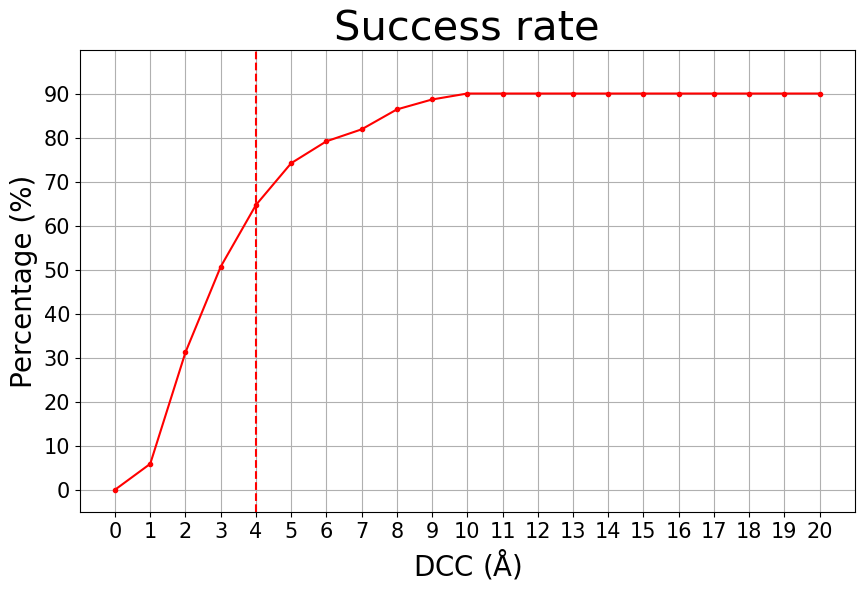

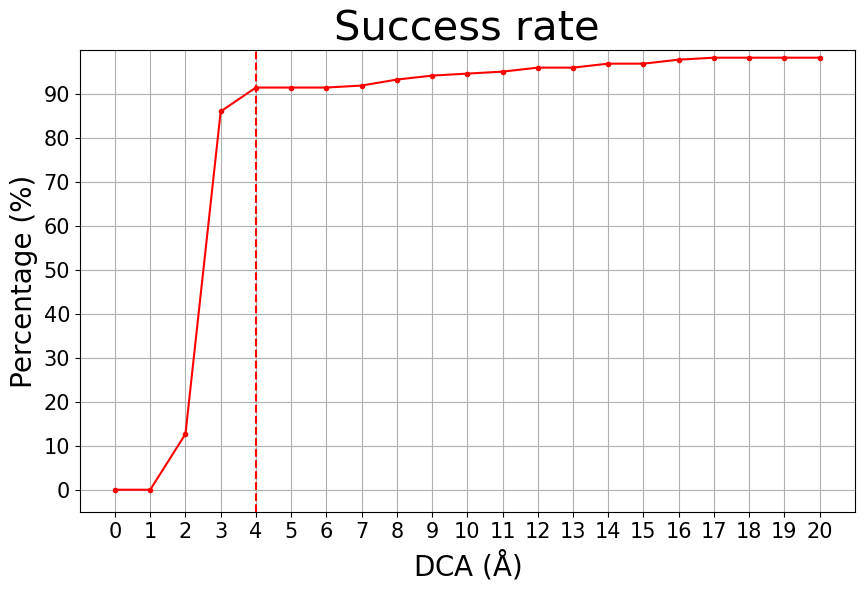

In [39]:
draw_DCC(dcc_scores, '.')
draw_DCA(dca_scores, '.')

In [40]:
import py3Dmol
import os
import random
import glob

def read_pdb_as_string(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def visualize_molecules_random():
    """
    Visualizes the protein, ligand, and predicted binding site using Py3Dmol.
    Randomly selects a directory from the specified paths.
    """
    base_path_gt = './coach420'
    base_path_output = './output/coach420'

    directories = [d for d in os.listdir(base_path_gt) if os.path.isdir(os.path.join(base_path_gt, d))]

    selected_dir = random.choice(directories)

    ligand_path = os.path.join(base_path_gt, selected_dir, 'ligand.mol2')
    protein_path = os.path.join(base_path_gt, selected_dir, 'protein.pdb')
    pocket_paths = glob.glob(os.path.join(base_path_output, selected_dir, 'pocket*.mol2'))

    if not pocket_paths:
        return

    pocket_path = pocket_paths[0]

    try:
        view = py3Dmol.view(width=800, height=400)

        protein_data = read_pdb_as_string(protein_path)
        ligand_data = read_pdb_as_string(ligand_path)
        pocket_data = read_pdb_as_string(pocket_path)

        if protein_data:
            view.addModel(protein_data, 'pdb')
            view.setStyle({'model': 0}, {'cartoon': {'color': 'white'}})
        if ligand_data:
            view.addModel(ligand_data, 'mol2')
            view.setStyle({'model': 1}, {'stick': {'radius': 0.3, 'color': 'red'}})
        if pocket_data:
            view.addModel(pocket_data, 'mol2')
            view.setStyle({'model': 2}, {'sphere': {'opacity': 0.5, 'color': 'blue'}})

        view.zoomTo()
        return view
    except Exception as e:
        print(f"An error occurred while setting up the visualization: {e}")

view = visualize_molecules_random()
if view:
    view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.